In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rprobertakaggle2/__results__.html
/kaggle/input/rprobertakaggle2/__notebook_source__.ipynb
/kaggle/input/rprobertakaggle2/__notebook__.ipynb
/kaggle/input/rprobertakaggle2/__output__.json
/kaggle/input/rprobertakaggle2/RoBERTa_model_weights.h5
/kaggle/input/rprobertakaggle2/custom.css
/kaggle/input/bertmodelweights/BERTmodel_weights.h5
/kaggle/input/redditresampled/rdResampled.csv


In [2]:
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, BertTokenizer, TFBertForSequenceClassification

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
#Load the tokenizer
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
#Load the model
model_roberta = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#Define the optimizer, loss, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
Accmetric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [6]:
#Compile the model
model_roberta.compile(optimizer=optimizer, loss=loss, metrics=[Accmetric])
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[Accmetric])

In [7]:
#Load the saved weights
model_roberta.load_weights('/kaggle/input/rprobertakaggle2/RoBERTa_model_weights.h5')
model_bert.load_weights('/kaggle/input/bertmodelweights/BERTmodel_weights.h5')

In [8]:
import emoji

def preprocess_emojis(texts):
    processed_texts = []
    
    for text in texts:
        processed_text = emoji.demojize(text)
        
        processed_text = processed_text.replace(":", "").replace("_", " ")
        
        processed_texts.append(processed_text)
    
    return processed_texts

In [9]:
def predict_classesConf(texts):
    label_mapping_reverse = {0: 'depression', 1: 'Anxiety', 2: 'bipolar', 3: 'BPD', 4: 'schizophrenia', 5: 'autism'}
    predicted_classes = []

    processed_texts = preprocess_emojis(texts)  # Call preprocess_emojis function

    for text in processed_texts:
        encoded_input_roberta = tokenizer_roberta.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_roberta = encoded_input_roberta["input_ids"]
        attention_mask_roberta = encoded_input_roberta["attention_mask"]

        encoded_input_bert = tokenizer_bert.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_bert = encoded_input_bert["input_ids"]
        attention_mask_bert = encoded_input_bert["attention_mask"]

        predictions_roberta = model_roberta.predict([input_ids_roberta, attention_mask_roberta])
        predictions_bert = model_bert.predict([input_ids_bert, attention_mask_bert])

        predicted_class_index_roberta = tf.argmax(predictions_roberta.logits, axis=1).numpy()[0]
        predicted_class_confidence_roberta = tf.nn.softmax(predictions_roberta.logits, axis=1).numpy()[0][predicted_class_index_roberta]

        predicted_class_index_bert = tf.argmax(predictions_bert.logits, axis=1).numpy()[0]
        predicted_class_confidence_bert = tf.nn.softmax(predictions_bert.logits, axis=1).numpy()[0][predicted_class_index_bert]

        if predicted_class_confidence_roberta > predicted_class_confidence_bert:
            predicted_class = label_mapping_reverse[predicted_class_index_roberta]
            predicted_confidence = predicted_class_confidence_roberta
            print('roberta')
        else:
            predicted_class = label_mapping_reverse[predicted_class_index_bert]
            predicted_confidence = predicted_class_confidence_bert
            print('bert')
        print(predicted_confidence)

        predicted_classes.append(predicted_class)

    return predicted_classes


In [10]:
def predict_classesWeightRob(texts):
    label_mapping_reverse = {0: 'depression', 1: 'Anxiety', 2: 'bipolar', 3: 'BPD', 4: 'schizophrenia', 5: 'autism'}
    predicted_classes = []

    processed_texts = preprocess_emojis(texts)  # Call preprocess_emojis function

    for text in processed_texts:
        encoded_input_roberta = tokenizer_roberta.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_roberta = encoded_input_roberta["input_ids"]
        attention_mask_roberta = encoded_input_roberta["attention_mask"]

        encoded_input_bert = tokenizer_bert.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_bert = encoded_input_bert["input_ids"]
        attention_mask_bert = encoded_input_bert["attention_mask"]

        predictions_roberta = model_roberta.predict([input_ids_roberta, attention_mask_roberta])
        predictions_bert = model_bert.predict([input_ids_bert, attention_mask_bert])

        weighted_probs = 0.7 * predictions_roberta.logits + 0.3 * predictions_bert.logits  # Adjust weights as desired
        predicted_class_index = tf.argmax(weighted_probs, axis=1).numpy()[0]
        predicted_class_confidence = tf.nn.softmax(weighted_probs, axis=1).numpy()[0][predicted_class_index]
        print(predicted_class_confidence)

        predicted_class = label_mapping_reverse[predicted_class_index]
#         if predicted_class_confidence > threshold:
#             predicted_class = label_mapping_reverse[predicted_class_index]
#         else:
#             predicted_class = 'None'

        predicted_classes.append(predicted_class)

    return predicted_classes


In [11]:
def predict_classesWeightBert(texts):
    label_mapping_reverse = {0: 'depression', 1: 'Anxiety', 2: 'bipolar', 3: 'BPD', 4: 'schizophrenia', 5: 'autism'}
    predicted_classes = []

    processed_texts = preprocess_emojis(texts)  # Call preprocess_emojis function

    for text in processed_texts:
        encoded_input_roberta = tokenizer_roberta.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_roberta = encoded_input_roberta["input_ids"]
        attention_mask_roberta = encoded_input_roberta["attention_mask"]

        encoded_input_bert = tokenizer_bert.encode_plus(text, truncation=True, padding=True, max_length=256, return_tensors='tf')
        input_ids_bert = encoded_input_bert["input_ids"]
        attention_mask_bert = encoded_input_bert["attention_mask"]

        predictions_roberta = model_roberta.predict([input_ids_roberta, attention_mask_roberta])
        predictions_bert = model_bert.predict([input_ids_bert, attention_mask_bert])

        weighted_probs = 0.3 * predictions_roberta.logits + 0.7 * predictions_bert.logits # Adjust weights as desired
        predicted_class_index = tf.argmax(weighted_probs, axis=1).numpy()[0]
        predicted_class_confidence = tf.nn.softmax(weighted_probs, axis=1).numpy()[0][predicted_class_index]
        print(predicted_class_confidence)

        predicted_class = label_mapping_reverse[predicted_class_index]
#         if predicted_class_confidence > threshold:
#             predicted_class = label_mapping_reverse[predicted_class_index]
#         else:
#             predicted_class = 'None'

        predicted_classes.append(predicted_class)

    return predicted_classes

In [22]:
original_text = ["I'm drowning in a sea of sadness... 😔💧 It feels like I'm suffocating and can't escape these \
overwhelming emotions. 😢💔 Every day is a struggle, and it's hard to see any light at the end of the tunnel. \
😞⛈️ My mind is a tornado of negative thoughts, spinning out of control. 🌪️😣 The weight on my chest is unbearable,\
and it's hard to breathe. 😫😭 #depression #mentalhealth"]


predicted_classes1 = predict_classesConf(original_text)
predicted_classes2 = predict_classesWeightRob(original_text)
predicted_classes3 = predict_classesWeightBert(original_text)


print('Confidence based',predicted_classes1)
print('Weight based roberta',predicted_classes2)
print('Weight based bert ',predicted_classes3)


1/1 [==============================] - 0s 48ms/step
roberta
0.9014857
1/1 [==============================] - 0s 47ms/step
0.88007766
1/1 [==============================] - 0s 45ms/step
0.8418347
Confidence based ['depression']
Weight based roberta ['depression']
Weight based bert  ['depression']


In [13]:
import pandas as pd 
df=pd.read_csv('/kaggle/input/redditresampled/rdResampled.csv')

In [14]:
df=df.drop(['Unnamed: 0'],axis=1)
df.head()

,title_post,Subreddit
0,The end of the road. I've never posted on redd...,depression
1,I can’t write comments. I think I should not c...,depression
2,Attempted hanging myself two years ago. So nea...,depression
3,"25/ f started deliberate self injury. Hi all, ...",depression
4,Venting I guess. I've been crying in my high s...,depression


In [15]:
df.count()

title_post    210000
Subreddit     210000
dtype: int64

In [16]:
X = df['title_post']
y = df['Subreddit']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
import numpy as np
# Combine X_test and y_test into a single dataset
combined_data = np.column_stack((X_test, y_test))

# Split the combined dataset into training and testing sets
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(combined_data[:, :-1], combined_data[:, -1], test_size=0.2, random_state=42)

In [19]:
len(new_X_test)

8400

In [22]:
predicted_classes1 = predict_classesConf(new_X_test[0:3])
print('original text ',predicted_classes1)

1/1 [==============================] - 0s 48ms/step
roberta
0.9719
1/1 [==============================] - 0s 43ms/step
roberta
0.996951
1/1 [==============================] - 0s 51ms/step
bert
0.9427723
original text  ['schizophrenia', 'bipolar', 'Anxiety']


# Making confidence based predictions # 

In [ ]:
#Making confidence based predictions
predicted_class_names = predict_classesConf(new_X_test)


In [26]:
len(predicted_class_names)

8400

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(new_y_test, predicted_class_names)

# Calculate precision
precision = precision_score(new_y_test, predicted_class_names, average='weighted')

# Calculate recall
recall = recall_score(new_y_test, predicted_class_names, average='weighted')

# Calculate F1 score
f1 = f1_score(new_y_test, predicted_class_names, average='weighted')

# Print the metrics
print('confidence voting metrics\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

confidence voting metrics

Accuracy: 0.8616666666666667
Precision: 0.8615318836611108
Recall: 0.8616666666666667
F1 Score: 0.8613407579259641


# Classification Report for confidence based predictions # 

In [31]:
# Calculate classification report 
classification_metrics = classification_report(new_y_test, predicted_class_names)
print(classification_metrics)


               precision    recall  f1-score   support

      Anxiety       0.87      0.85      0.86      1389
          BPD       0.81      0.82      0.81      1406
       autism       0.97      1.00      0.98      1415
      bipolar       0.83      0.78      0.80      1396
   depression       0.78      0.82      0.80      1409
schizophrenia       0.91      0.91      0.91      1385

     accuracy                           0.86      8400
    macro avg       0.86      0.86      0.86      8400
 weighted avg       0.86      0.86      0.86      8400



# Confsion Matrix for confidence based predictions # 

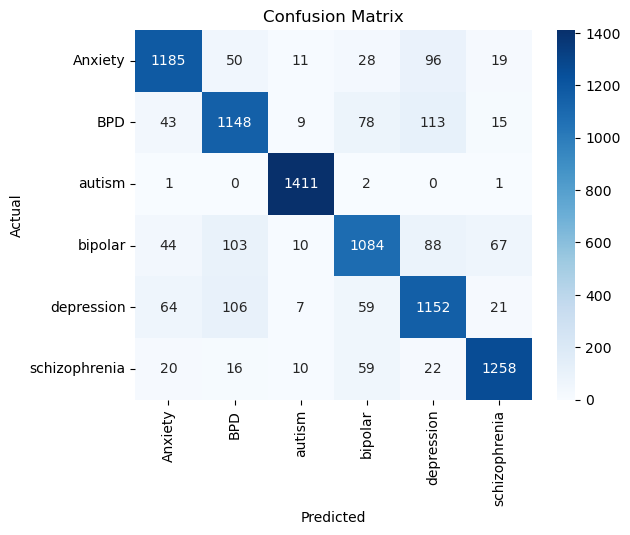

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtain confusion matrix 
confusion = confusion_matrix(new_y_test, predicted_class_names)

# Convert confusion matrix to a DataFrame for better visualization
labels = ['Anxiety', 'BPD', 'autism', 'bipolar','depression', 'schizophrenia']

confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Making weight based predictions Roberta (0.7) #  

In [33]:
#Making weight based predictions
predicted_class_namesW = predict_classesWeightRob(new_X_test)

1/1 [==============================] - 0s 50ms/step
0.95809656
1/1 [==============================] - 0s 53ms/step
0.99715614
1/1 [==============================] - 0s 57ms/step
0.66584337
1/1 [==============================] - 0s 53ms/step
0.9998934
1/1 [==============================] - 0s 52ms/step
0.95328754
1/1 [==============================] - 0s 78ms/step
0.45485714
1/1 [==============================] - 0s 84ms/step
0.5317889
1/1 [==============================] - 0s 73ms/step
0.99985564
1/1 [==============================] - 0s 97ms/step
0.9835286
1/1 [==============================] - 0s 86ms/step
0.99708986
1/1 [==============================] - 0s 73ms/step
0.9462029
1/1 [==============================] - 0s 57ms/step
0.99881124
1/1 [==============================] - 0s 61ms/step
0.9904174
1/1 [==============================] - 0s 57ms/step
0.9826751
1/1 [==============================] - 0s 54ms/step
0.996243
1/1 [==============================] - 0s 55ms/step
0.9912423
1

In [34]:
len(predicted_class_namesW)

8400

In [39]:
# Calculate accuracy
accuracy = accuracy_score(new_y_test, predicted_class_namesW)

# Calculate precision
precision = precision_score(new_y_test, predicted_class_namesW, average='weighted')

# Calculate recall
recall = recall_score(new_y_test, predicted_class_namesW, average='weighted')

# Calculate F1 score
f1 = f1_score(new_y_test, predicted_class_namesW, average='weighted')

# Print the metrics
print('weighted voting metrics\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


weighted voting metrics

Accuracy: 0.8590476190476191
Precision: 0.8597338641647498
Recall: 0.8590476190476191
F1 Score: 0.8590679894559307


# Classification Report for weight based predictions # 

In [36]:
# Calculate classification report 
classification_metrics = classification_report(new_y_test, predicted_class_namesW)
print(classification_metrics)


               precision    recall  f1-score   support

      Anxiety       0.88      0.84      0.86      1389
          BPD       0.81      0.80      0.80      1406
       autism       0.97      1.00      0.98      1415
      bipolar       0.81      0.79      0.80      1396
   depression       0.77      0.83      0.80      1409
schizophrenia       0.92      0.90      0.91      1385

     accuracy                           0.86      8400
    macro avg       0.86      0.86      0.86      8400
 weighted avg       0.86      0.86      0.86      8400



# Confusion Matrix for weight based predictions # 

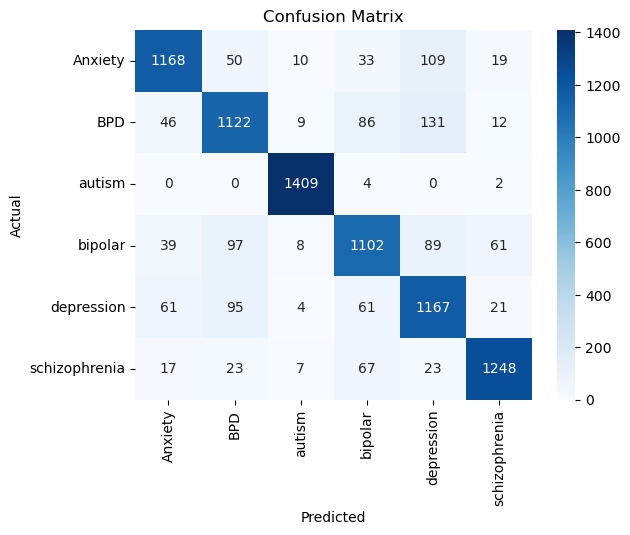

In [37]:
# Obtain confusion matrix 
confusion = confusion_matrix(new_y_test, predicted_class_namesW)

# Convert confusion matrix to a DataFrame for better visualization
labels = ['Anxiety', 'BPD', 'autism', 'bipolar','depression', 'schizophrenia']

confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Making weight based predictions Bert (0.7)#  

In [23]:
predicted_classes1 = predict_classesWeightBert(new_X_test)
print('original text ',predicted_classes1)

1/1 [==============================] - 0s 44ms/step
0.92923206
1/1 [==============================] - 0s 44ms/step
0.99705315
1/1 [==============================] - 0s 52ms/step
0.8720921
original text  ['schizophrenia', 'bipolar', 'Anxiety']


In [ ]:
#Making weight based predictions
predicted_class_namesWB = predict_classesWeightBert(new_X_test)

1/1 [==============================] - 0s 52ms/step
0.92923206
1/1 [==============================] - 0s 47ms/step
0.99705315
1/1 [==============================] - 0s 50ms/step
0.8720921
1/1 [==============================] - 0s 48ms/step
0.9999081
1/1 [==============================] - 0s 58ms/step
0.9839331
1/1 [==============================] - 0s 45ms/step
0.3783829
1/1 [==============================] - 0s 51ms/step
0.9379498
1/1 [==============================] - 0s 47ms/step
0.9998796
1/1 [==============================] - 0s 53ms/step
0.9712922
1/1 [==============================] - 0s 55ms/step
0.9969516
1/1 [==============================] - 0s 50ms/step
0.92894423
1/1 [==============================] - 0s 51ms/step
0.998743
1/1 [==============================] - 0s 81ms/step
0.98700434
1/1 [==============================] - 0s 85ms/step
0.98471916
1/1 [==============================] - 0s 84ms/step
0.99454945
1/1 [==============================] - 0s 65ms/step
0.99036205
1/

In [25]:
len(predicted_class_namesWB)

8400

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(new_y_test, predicted_class_namesWB)

# Calculate precision
precision = precision_score(new_y_test, predicted_class_namesWB, average='weighted')

# Calculate recall
recall = recall_score(new_y_test, predicted_class_namesWB, average='weighted')

# Calculate F1 score
f1 = f1_score(new_y_test, predicted_class_namesWB, average='weighted')

# Print the metrics
print('weighted voting metrics\n')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

weighted voting metrics

Accuracy: 0.8602380952380952
Precision: 0.8607240989575827
Recall: 0.8602380952380952
F1 Score: 0.8601879205919865


# Classification Report for weight based predictions Bert # 

In [27]:
# Calculate classification report 
classification_metrics = classification_report(new_y_test, predicted_class_namesWB)
print(classification_metrics)

               precision    recall  f1-score   support

      Anxiety       0.86      0.86      0.86      1389
          BPD       0.77      0.83      0.80      1406
       autism       0.98      1.00      0.99      1415
      bipolar       0.83      0.78      0.80      1396
   depression       0.80      0.78      0.79      1409
schizophrenia       0.92      0.91      0.91      1385

     accuracy                           0.86      8400
    macro avg       0.86      0.86      0.86      8400
 weighted avg       0.86      0.86      0.86      8400



# Confusion Matrix for weight based predictions Bert # 

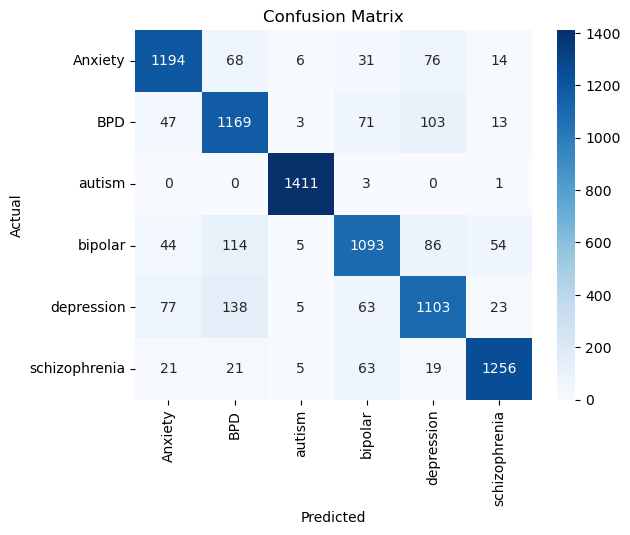

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Obtain confusion matrix 
confusion = confusion_matrix(new_y_test, predicted_class_namesWB)

# Convert confusion matrix to a DataFrame for better visualization
labels = ['Anxiety', 'BPD', 'autism', 'bipolar','depression', 'schizophrenia']

confusion_df = pd.DataFrame(confusion, index=labels, columns=labels)

# Create a heatmap of the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()